In [ ]:
# convert a video into its animated form

In [83]:
# imports 

from PIL import Image 
from tqdm import tqdm
import shutil
import scipy.ndimage
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
import cv2
import glob

# globals 

# root 
root_path = '/home/linuxdualboot/github/misc projects/lover'

# path for most images 
path = root_path + '/video'

# path for secondary images 
path2 = root_path + '/video2'

# change to root directory 
os.chdir(root_path)

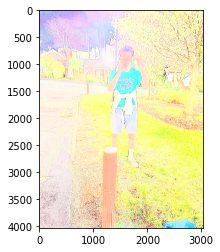

In [67]:
# test individual image, basic functions


# layer images on top of one another 
def dodge(front,back):
    # The formula comes from http://www.adobe.com/devnet/pdf/pdfs/blend_modes.pdf
    result=back*256.0/(256.0-front) 
    result[result>255]=255
    result[front==255]=255
    return result.astype('uint8')


# original grayscale formula
def grayscale(rgb):
    return np.dot(rgb, [0.299, 0.587, 0.114])


# test image 
img ="picture.jpg"

# read image 
s = imageio.imread(img)

# delete
g = grayscale(s)

# take average of rgb values down the z axis instead of grayscale function 
new_arr = np.array(s).mean(axis=(2))


# create ndarray for image (three of the average ndarrays, with axes swapped)
# make this faster by not having to switch axes?
a = [new_arr, new_arr, new_arr]
arr1 = np.asarray(a).astype(np.uint8)
arr1 = np.swapaxes(arr1, 0, 2)
arr1 = np.swapaxes(arr1, 0, 1)



diff = (s - arr1).astype(np.uint8)
arr1 = diff + arr1



# inverse
i = 255 - arr1

# blur the inverse, higher sigma = more run time + deeper blur 
b = scipy.ndimage.filters.gaussian_filter(i,sigma=5)

# combine 
r = dodge(b,arr1)


# display 
%matplotlib inline 
plt.imshow(r)


# save 
plt.imsave('img2.jpg', r, vmin=0, vmax=255)


In [139]:
# creation of a folder, skip 

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)
try:
    os.mkdir(path2)
except OSError:
    print ("Creation of the directory %s failed" % path2)
else:
    print ("Successfully created the directory %s " % path2)

Creation of the directory /home/linuxdualboot/github/misc projects/lover/video failed
Creation of the directory /home/linuxdualboot/github/misc projects/lover/video2 failed


In [143]:
# delete all of the current photos in the directory to make space for the new ones 


os.chdir(root_path)
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
    
    
# update values everywhere so that this works 
new_frame_rate_change = 0.5


# print information about the video to be editted 
cap = cv2.VideoCapture("video.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = frame_count/fps

print('fps = ' + str(fps))
print('number of frames = ' + str(frame_count))
print('duration (S) = ' + str(duration))

minutes = int(duration/60)
seconds = duration%60

print('duration (M:S) = ' + str(minutes) + ':' + str(seconds))

cap.release()

fps = 30.06779192344567
number of frames = 737
duration (S) = 24.511277777777778
duration (M:S) = 0:24.511277777777778


In [144]:
# go to root path to collect video 
os.chdir(root_path)
vidcap = cv2.VideoCapture('video.mp4')
success,image = vidcap.read()

# back to video images path
os.chdir(path)
frames = 0

# write the frames of the video into the video folder according to frame rate variable 
while success:
    if frames % int(1/new_frame_rate_change) == 0:
        success,image = vidcap.read()
        if success:
            cv2.imwrite("%d.jpg" % frames, image)     # save frame as JPEG file
    else:
        success,image = vidcap.read()
    frames += 1

In [145]:
# names of file destinations for images to be overlayed in the future 

contours_ = []
grayed = []

In [147]:
# create grayscale and blurred images for video frames 

counter = 0 
os.chdir(path)

for filename in tqdm(os.listdir(path)):
    img = path + "/" + str(counter) + ".jpg"

    s = imageio.imread(img)

        
    if counter <= 400:
        new_arr = np.array(s).mean(axis=(2))

        # make this faster by not having to switch axes twice or at all?
        a = [new_arr, new_arr, new_arr]
        r = np.asarray(a).astype(np.uint8)
        r = np.swapaxes(r, 0, 2)
        r = np.swapaxes(r, 0, 1)


        diff = (((counter)/400) * (s - r)).astype(np.uint8)
        r = diff + r 
 
        
        i = (255)-r
        b = scipy.ndimage.filters.gaussian_filter(i,sigma=5)
        r = dodge(b,r)
    else:
        i = (255)-s
        b = scipy.ndimage.filters.gaussian_filter(i,sigma=5)
        r = dodge(b,s)

        

        
    os.remove(img) 
    plt.imsave(img, r, vmin=0, vmax=255)
    grayed.append(path +"/" + filename)

    counter += 2


100%|██████████| 365/365 [01:58<00:00,  3.08it/s]


In [148]:
# find contour images 

counter = 0
os.chdir(path2)

for filename in tqdm(os.listdir(path)):
    image = cv2.imread(path + "/" + str(counter) + ".jpg") 
  
    # Grayscale 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

    # Find Canny edges 
    edged = cv2.Canny(gray, 30, 200) 

    # Finding Contours 
    # Use a copy of the image e.g. edged.copy() 
    # since findContours alters the image 
    contours, hierarchy = cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) 

    # Draw all contours 
    # -1 signifies drawing all contours 
    cv2.drawContours(image, contours, -1, (10, 0, 10), 3) 

    plt.imsave(path2 + "/" + str(counter) + ".jpg", image, vmin=0, vmax=255)
    contours_.append(path2+'/' + str(counter) + '.jpg')
    counter += 2


100%|██████████| 365/365 [00:39<00:00,  9.30it/s]


In [30]:
# combine mock sketches and contoured images 

length = len(contours_)
print(length)
print(len(grayed))
# assert (length == len(grayed))

os.chdir(root_path)

for i in range(length):
    try:
        first_image = Image.open('video/' + str(i * 2) + '.jpg')
        second_image = Image.open('video2/' + str(i * 2) + '.jpg')
        plt.show(first_image)
        first_image.paste(second_image, (0,0))
        os.remove(contours_[i]) 
        plt.imsave(contours_[i], first_image, vmin=0, vmax=255)
    except:
        pass


224
112


In [149]:
# combine frames into a final video 

img_array_sorted = []
counter = 0 

for filename in os.listdir(path2):
    
    img = cv2.imread(path2 + "/" + str(counter) + ".jpg")
    try:
        height, width, layers = img.shape
        size = (width,height)
        img_array_sorted.append(img)
    except:
        pass
    counter += int(1/new_frame_rate_change)


os.chdir(root_path)
out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), int(fps*new_frame_rate_change), size)
 
for i in range(len(img_array_sorted)):
    out.write(img_array_sorted[i])
out.release()

In [ ]:
# turn everything into functions, eventually condense everything into a class

# get correct folder full of contoured images

# get correct overlaying of contoured images and grayscaled images 

# figure out frame rate equations 

# create a set of darker/lighter images such that the contours for them will be more or less, 
# overlay them occasionally in final video to make it look more like an animation 

# figure out more about the dodge function 